In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 31.07 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
#Get the data
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d0aebfc5990>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

Text(0.5, 1.0, 'sushi')

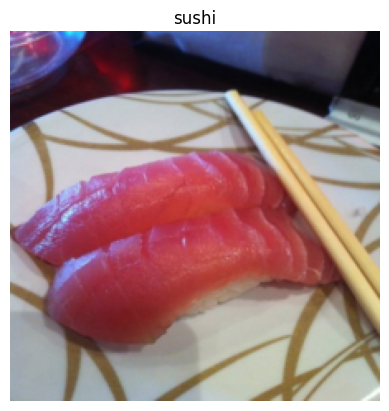

In [8]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])

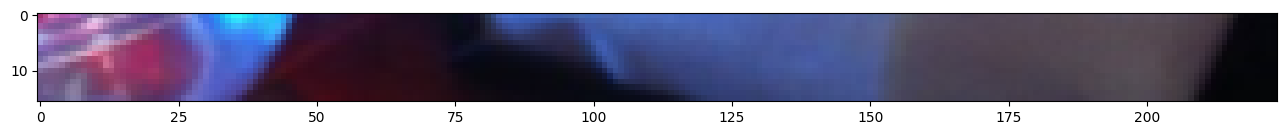

In [9]:
# Equation 1 Split data into pathces and creating the class position and patch embedding
#Get the top row of the image
image_permuted = image.permute(1,2,0)

#Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:
                          ])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


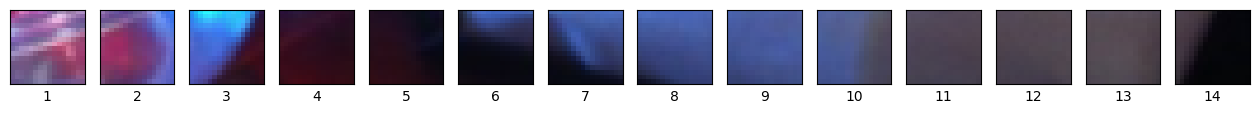

In [10]:
#Setup code to plot top row as patches
img_size=224
patch_size = 16
num_patches=img_size/patch_size
assert img_size%patch_size==0, "Image size must be divisible by patch_size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

#Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size//patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size,patch_size))


#Iterate through number of patches in the top row
for i, patch in enumerate(range(0,img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


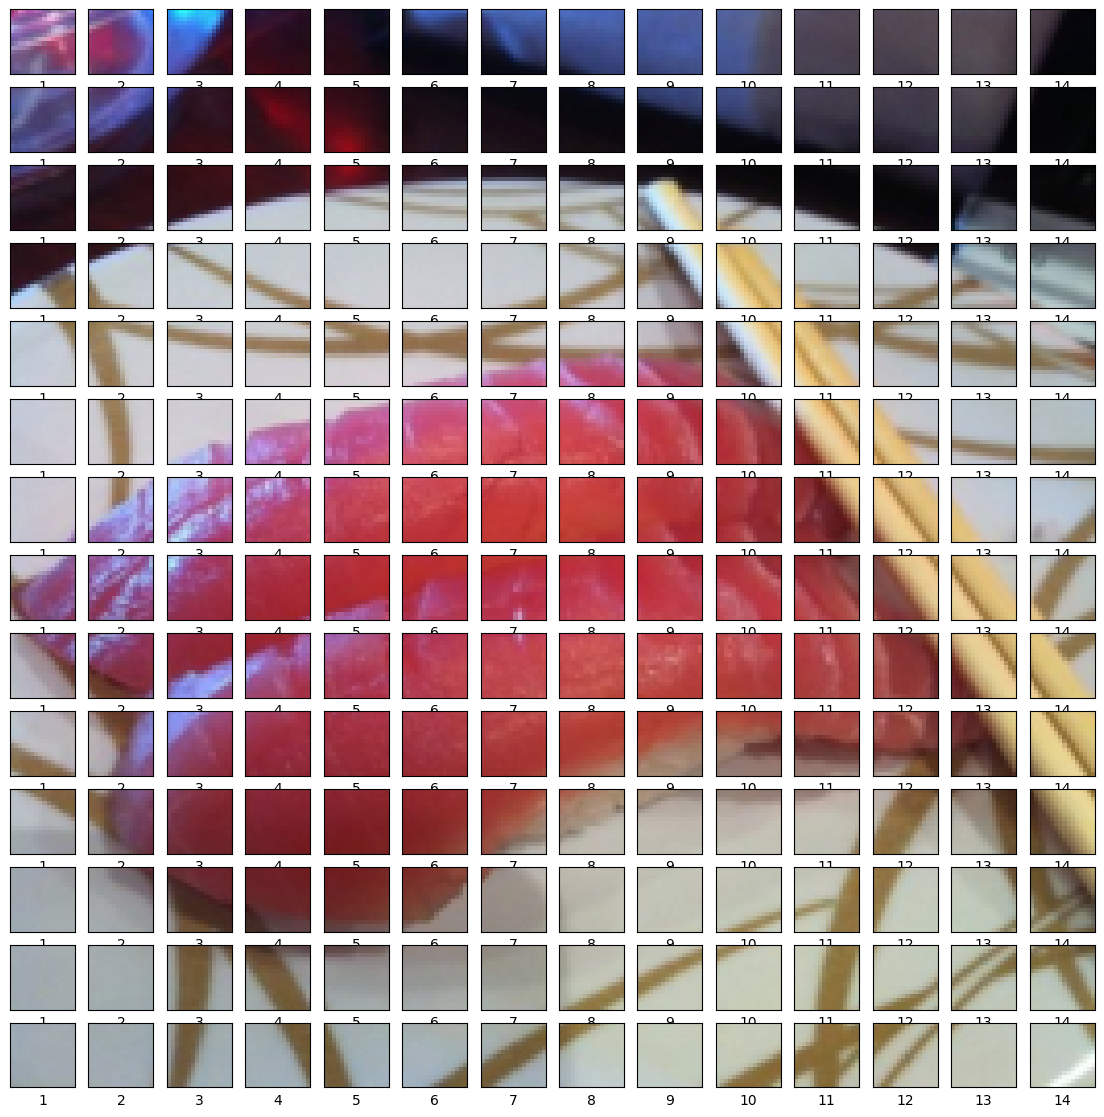

In [11]:
#Setup code to plot whole image as patches
img_size=224
patch_size = 16
num_patches=img_size/patch_size
assert img_size%patch_size==0, "Image size must be divisible by patch_size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")


#Create a series of subplots
fig, axs = plt.subplots(nrows=img_size//patch_size,
                        ncols=img_size//patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(num_patches,num_patches))


#Iterate through height and width of image
for i, patch_height in enumerate(range(0,img_size, patch_size)):
  for j, patch_width in enumerate(range(0,img_size, patch_size)):
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :]);
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])

In [12]:
# Creating images patches and turning them into patch embeddings
#Create a Conv2d layer to turn images into patches of learnable feature map embeddings
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels = 768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

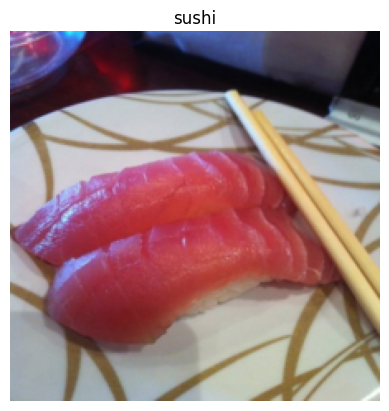

In [13]:
#View a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [14]:
#Pass the image through conv layer
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)
image_out_of_conv

torch.Size([1, 768, 14, 14])


tensor([[[[ 1.0194e-01, -9.0233e-02,  3.3487e-01,  ...,  3.5226e-02,
            6.6236e-02,  3.4695e-02],
          [ 5.2493e-02,  2.0401e-01, -1.0123e-02,  ...,  5.0390e-02,
            1.1702e-01,  1.0391e-02],
          [ 5.8638e-02, -1.1565e-02, -1.2738e-01,  ...,  2.3830e-02,
            1.0292e-02,  2.4893e-02],
          ...,
          [ 7.4871e-02,  6.2842e-02, -3.3038e-03,  ...,  2.4903e-03,
            8.7883e-02,  1.0951e-01],
          [ 9.4065e-02,  8.3099e-02, -1.3862e-01,  ...,  9.3901e-02,
            7.9148e-03, -4.0703e-02],
          [ 8.1736e-02,  9.1377e-02, -1.3203e-02,  ...,  4.9636e-02,
            8.4141e-02,  5.5052e-02]],

         [[-8.9775e-01, -4.4952e-01, -6.4814e-01,  ..., -4.4169e-01,
           -4.4811e-01, -1.1828e-01],
          [-5.8794e-01, -4.8437e-01, -1.8137e-01,  ..., -3.5013e-01,
           -3.5602e-01, -7.0392e-02],
          [-2.0307e-01, -1.5729e-01, -2.7050e-01,  ..., -9.9598e-02,
           -2.1724e-01, -1.6253e-01],
          ...,
     

In [15]:
# Flattening the patch embedding with torch.nn.Flatten
flatten_layer = nn.Flatten(start_dim=2,end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape; torch.Size([3, 224, 224])
Image feature map(patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


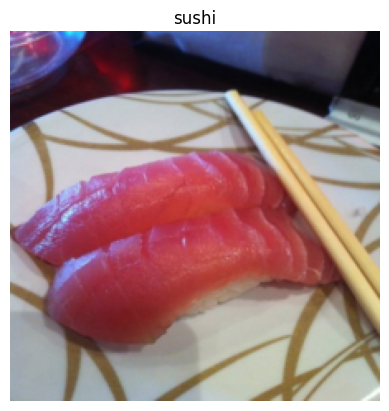

In [16]:
#Put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape; {image.shape}")


image_out_of_conv = conv2d(image.unsqueeze(0))

print(f"Image feature map(patches) shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [17]:
#rearrange output layer of flattened layer
image_out_of_conv_flattened_reshaped=image_out_of_conv_flattened.permute(0,2,1)

In [18]:
#Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]
single_flattened_feature_map

tensor([[ 0.1019, -0.0902,  0.3349, -0.0030,  0.0199,  0.0778,  0.0796,  0.1143,
          0.1091,  0.1554,  0.0450,  0.0352,  0.0662,  0.0347,  0.0525,  0.2040,
         -0.0101, -0.0319, -0.0664,  0.0088,  0.0152,  0.0129,  0.0454,  0.0890,
          0.0623,  0.0504,  0.1170,  0.0104,  0.0586, -0.0116, -0.1274, -0.1693,
          0.0343,  0.0298,  0.0205,  0.0550,  0.2513,  0.0743,  0.0168,  0.0238,
          0.0103,  0.0249, -0.1603,  0.0380,  0.1567,  0.0436,  0.0974,  0.0791,
          0.0681,  0.1716, -0.3316,  0.0074,  0.0620, -0.0144,  0.0427,  0.0972,
          0.0932,  0.0674,  0.0448,  0.0509, -0.0954,  0.0281,  0.0751,  0.0396,
          0.0376,  0.1141, -0.1407,  0.0669,  0.0311,  0.1405,  0.0804, -0.1904,
          0.1036,  0.0397, -0.0997, -0.1055, -0.1055, -0.0631, -0.0868, -0.0775,
          0.1119, -0.0249,  0.0665,  0.1016,  0.0980,  0.1369, -0.0574, -0.0298,
         -0.0943, -0.0842, -0.1353, -0.1237, -0.1304, -0.0924, -0.2427, -0.0502,
          0.0005,  0.1217,  

(-0.5, 195.5, 0.5, -0.5)

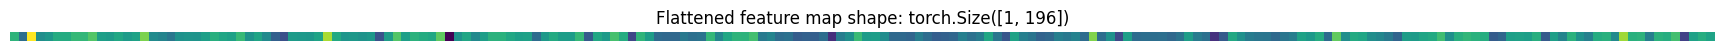

In [19]:
#Plot the flattened feature map visually
plt.figure(figsize=(22,22))

plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [20]:
# Turning the ViT patch embedding layer into a Pytorch module

class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               patch_size: int=16,
               embedding_dim: int=768):
    super().__init__()
    self.patch_size=patch_size

    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding=0)
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)
  def forward(self, x ):
    image_resolution = x.shape[-1]
    assert image_resolution%patch_size ==0, f" Input image size must be divisible by patch size, image shape: {image_resolution}, patch_sizze: {self.patch_size}"

    x_patched = self.patcher(x)
    x_flattened= self.flatten(x_patched)
    return x_flattened.permute(0,2,1)


In [21]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Imput image size : { image.unsqueeze(0).shape}")

patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Imput image size : torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [22]:
# Creating class token embeddiing
#Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [23]:
#Create class token embedding as a learnable parameter that share the same size as the embedding dimnesion
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                                      requires_grad=True)
class_token

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [24]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image),
                                                      dim=1) #number of patched dimension

print(patch_embedded_image_with_class_embedding.shape)


torch.Size([1, 197, 768])


In [25]:
# Creating the position embedding
#View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.6294,  0.0548,  0.0770,  ...,  0.4423, -0.2805,  0.0174],
          [-0.4595,  0.2071, -0.0430,  ...,  0.2208, -0.2003,  0.2583],
          ...,
          [-0.8163,  0.2246, -0.3183,  ...,  0.4861, -0.1710,  0.2909],
          [-0.8273,  0.2491, -0.2428,  ...,  0.5886, -0.3567,  0.2851],
          [-0.7853,  0.1278, -0.2813,  ...,  0.6899, -0.3193,  0.2786]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [26]:
#Calculate N number of patches
height:int=224
width:int=224
number_of_patches = int((height*width)/patch_size**2)
number_of_patches


196

In [27]:
#Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
embedding_dimension

768

In [28]:
#Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [29]:
#Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding.shape)

torch.Size([1, 197, 768])


In [30]:
# Putting it all together from image to embedding
set_seeds()

#1. Set the patch size
patch_size=16

#2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: { image.shape}")
height, width = image.shape[1], image.shape[2]

#3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

#4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels =3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

#5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

#6. Create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dim=patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

#7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: { patch_embedding_class_token.shape}")

#8. Create position embedding
number_of_patches = int((height*width)//patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

#9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [31]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multihead self attention block ("MSA Blockfor short").
  """
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:int=0):
    super().__init__()

    #Create the norm layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    #Create multihead attention
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) #is the batch first? (batch, seq, feature)-> (batch, number of patches, embdedding_dimension)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output

In [32]:
#Create an instance MSA Block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)
#Pass the patch and position image embedding sequence through the msa block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of msa block: {patch_and_position_embedding.shape}")
print(f"Output shape of msa block: {patched_image_through_msa_block.shape}")

Input shape of msa block: torch.Size([1, 197, 768])
Output shape of msa block: torch.Size([1, 197, 768])


In [33]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3706, 1.0548, 1.0770,  ..., 1.4423, 0.7195, 1.0174],
         [0.5405, 1.2071, 0.9570,  ..., 1.2208, 0.7997, 1.2583],
         ...,
         [0.1837, 1.2246, 0.6817,  ..., 1.4861, 0.8290, 1.2909],
         [0.1727, 1.2491, 0.7572,  ..., 1.5886, 0.6433, 1.2851],
         [0.2147, 1.1278, 0.7187,  ..., 1.6899, 0.6807, 1.2786]]],
       grad_fn=<AddBackward0>)

In [34]:
patched_image_through_msa_block

tensor([[[-0.2563, -0.2337,  0.1024,  ..., -0.4811,  0.9285, -0.5121],
         [-0.2418, -0.2246,  0.1086,  ..., -0.4814,  0.9470, -0.5343],
         [-0.2452, -0.2276,  0.1168,  ..., -0.4812,  0.9459, -0.5319],
         ...,
         [-0.2381, -0.2160,  0.1083,  ..., -0.4863,  0.9497, -0.5351],
         [-0.2377, -0.2152,  0.1116,  ..., -0.4856,  0.9491, -0.5355],
         [-0.2380, -0.2144,  0.1108,  ..., -0.4867,  0.9509, -0.5351]]],
       grad_fn=<TransposeBackward0>)

In [35]:
#Equation 3: Multilayer perceptron block
class MLPBlock(nn.Module):
  """Creates a multihead self attention block ("MSA Blockfor short").
  """
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()

    #Create the norm layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    #Create MLP
    self.mlp = nn.Sequential(nn.Linear(in_features=embedding_dim,
                                      out_features=mlp_size),
                             nn.GELU(),
                             nn.Dropout(p=dropout),
                             nn.Linear(in_features=mlp_size,
                                       out_features=embedding_dim),
                             nn.Dropout(p=dropout))

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    #return self.mlp(self.layer_norm(x)) leveraging the argument fusion

In [36]:
#Create an instance of mlp block
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

#Pass the output of msa block thorugh mlp block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

print(f"Input shape of mlp block: {patched_image_through_msa_block.shape}")
print(f"Output shape of mlp block: {patched_image_through_mlp_block.shape}")

Input shape of mlp block: torch.Size([1, 197, 768])
Output shape of mlp block: torch.Size([1, 197, 768])


In [37]:
patched_image_through_msa_block

tensor([[[-0.2563, -0.2337,  0.1024,  ..., -0.4811,  0.9285, -0.5121],
         [-0.2418, -0.2246,  0.1086,  ..., -0.4814,  0.9470, -0.5343],
         [-0.2452, -0.2276,  0.1168,  ..., -0.4812,  0.9459, -0.5319],
         ...,
         [-0.2381, -0.2160,  0.1083,  ..., -0.4863,  0.9497, -0.5351],
         [-0.2377, -0.2152,  0.1116,  ..., -0.4856,  0.9491, -0.5355],
         [-0.2380, -0.2144,  0.1108,  ..., -0.4867,  0.9509, -0.5351]]],
       grad_fn=<TransposeBackward0>)

In [38]:
patched_image_through_mlp_block

tensor([[[-0.0803,  0.0020,  0.1077,  ..., -0.0000, -0.1551,  0.1690],
         [-0.1356, -0.1266,  0.2197,  ..., -0.1230, -0.1338,  0.1929],
         [-0.0551, -0.0393,  0.2396,  ..., -0.0000, -0.1936,  0.1818],
         ...,
         [-0.2315, -0.0127,  0.2118,  ...,  0.1069, -0.2049,  0.2622],
         [-0.1768,  0.0407,  0.0000,  ...,  0.0461, -0.1824,  0.0719],
         [-0.1059, -0.0287,  0.1689,  ..., -0.1153, -0.1645,  0.1708]]],
       grad_fn=<MulBackward0>)

In [39]:
# Creating the custom Transformer Encoder code
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size: int=3072,
               mlp_dropout:int=0.1,
               attn_dropout:int=0):
    super().__init__()

    #Create MSA block
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    #Create MLP Block
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self,x):
    x = self.msa_block(x) + x #residual connection/skip connection
    x = self.mlp_block(x) + x #residual/skip connection
    return x

In [40]:
#Create an instance of transformer encoder code
transformer_encoder_block = TransformerEncoderBlock()

#Get a summary with torchinfo. summary

summary(model=transformer_encoder_block,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [41]:
# Create a transformer encoder layer with built in Pytorch layers

In [42]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first = True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [43]:

summary(model=torch_transformer_encoder_layer,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [44]:
#Putting it all together to create ViT

class ViT(nn.Module):
  def __init__(self,
               img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim: int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout: int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1,
               num_classes:int=1000):

    super().__init__()
    #Make an assertion that the image size is compatible with the patch size
    assert img_size%patch_size==0, f"Image must be divisible by patch size, image: {img_size}, patch_size: {patch_size}"

    #Calculate the number of patches(height*weight/patch^2)
    self.num_patches=(img_size*img_size)//patch_size**2

    #Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding =nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                       requires_grad=True)

    #Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1, embedding_dim))

    #Create embedding dropout value
    self.embedding_dropout=nn.Dropout(p=embedding_dropout)

    #Create patch embedding layer
    self.patch_embedding=PatchEmbedding(in_channels=in_channels,
                                        patch_size=patch_size,
                                        embedding_dim=embedding_dim)

    #Create transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    #Create classifier head
    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                    nn.Linear(in_features=embedding_dim,
                                              out_features=num_classes))

  def forward(self,x):
    #Get the batch size
    batch_size = x.shape[0]

    #Create class token embedding and expand it to match the batch size equation 1
    class_token = self.class_embedding.expand(batch_size,-1,-1) #"-1" means to infer the dimensions

    #Create the patch embedding equation 1
    x = self.patch_embedding(x)

    #Concat class token embedding and patch embedding equation 1
    x = torch.cat((class_token,x), dim=1) #Batch_size, number_of_pathces, embedding_dim

    #Add the position embedding to class token and patch embedding
    x = self.position_embedding + x

    #Apply dropout to patch embedding
    x = self.embedding_dropout(x)

    #Pass position and patch embedding to Transformer Encoder equation 2 and 3
    x = self.transformer_encoder(x)

    #Put 0th index logit through classifier equation 4
    x = self.classifier(x[:,0])

    return x

In [45]:
batch_size=32
embedding_dim=768
class_embedding =nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                       requires_grad=True)
class_embedding_expanded= class_embedding.expand(batch_size,-1,-1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [46]:
vit=ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [47]:
set_seeds()

#Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1,3,224,224)

vit = ViT(num_classes=len(class_names))

#Pass the random image to our Vit instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [48]:
#gettting a visual summary of our Vit model
summary(model=ViT(num_classes=1000),
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

In [49]:
#Setting uo training code for our custom Vit
optimizer = torch.optim.Adam(vit.parameters(), lr=0.001, betas=(0.9,0.999),weight_decay=0.1)

In [50]:
loss_fn = torch.nn.CrossEntropyLoss()

In [51]:
#Training out vit model
from going_modular.going_modular import engine
results = engine.train(model=vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn,epochs=10,device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.3987 | train_acc: 0.2891 | test_loss: 1.0305 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.4414 | train_acc: 0.3047 | test_loss: 1.3080 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.7541 | train_acc: 0.2812 | test_loss: 2.1978 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.3913 | train_acc: 0.3164 | test_loss: 1.0644 | test_acc: 0.3797
Epoch: 5 | train_loss: 1.1751 | train_acc: 0.3008 | test_loss: 1.9746 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.2151 | train_acc: 0.3867 | test_loss: 1.1015 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.2195 | train_acc: 0.3047 | test_loss: 1.1348 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.2462 | train_acc: 0.4180 | test_loss: 1.4212 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1775 | train_acc: 0.3945 | test_loss: 1.7268 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.2192 | train_acc: 0.2734 | test_loss: 1.0408 | test_acc: 0.5417


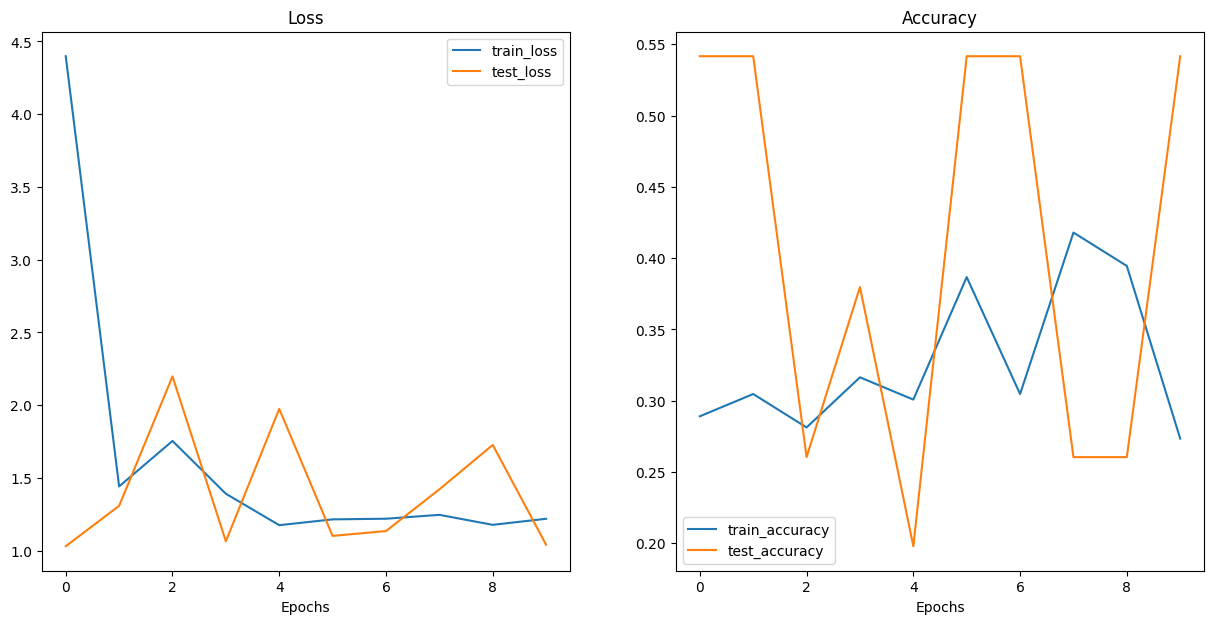

In [52]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [59]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

#Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad=False
#Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [60]:
summary(model=pretrained_vit,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [63]:
#Get automatic transforms from pretrained vit weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [66]:
#Setup dataloader
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32)

In [69]:
#Setting uo training code for our custom Vit
optimizer = torch.optim.Adam(pretrained_vit.parameters(), lr=0.001, betas=(0.9,0.999),weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss()
results1 = engine.train(model=pretrained_vit, train_dataloader=train_dataloader_pretrained, test_dataloader=test_dataloader_pretrained, optimizer=optimizer, loss_fn=loss_fn,epochs=10,device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8472 | train_acc: 0.6797 | test_loss: 0.5354 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3554 | train_acc: 0.9414 | test_loss: 0.3268 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.2437 | train_acc: 0.9492 | test_loss: 0.2676 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1791 | train_acc: 0.9492 | test_loss: 0.2559 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1488 | train_acc: 0.9570 | test_loss: 0.2449 | test_acc: 0.9186
Epoch: 6 | train_loss: 0.1372 | train_acc: 0.9727 | test_loss: 0.2296 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.1137 | train_acc: 0.9766 | test_loss: 0.2126 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.1028 | train_acc: 0.9766 | test_loss: 0.2083 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.1026 | train_acc: 0.9766 | test_loss: 0.2060 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.0880 | train_acc: 0.9844 | test_loss: 0.2011 | test_acc: 0.9176


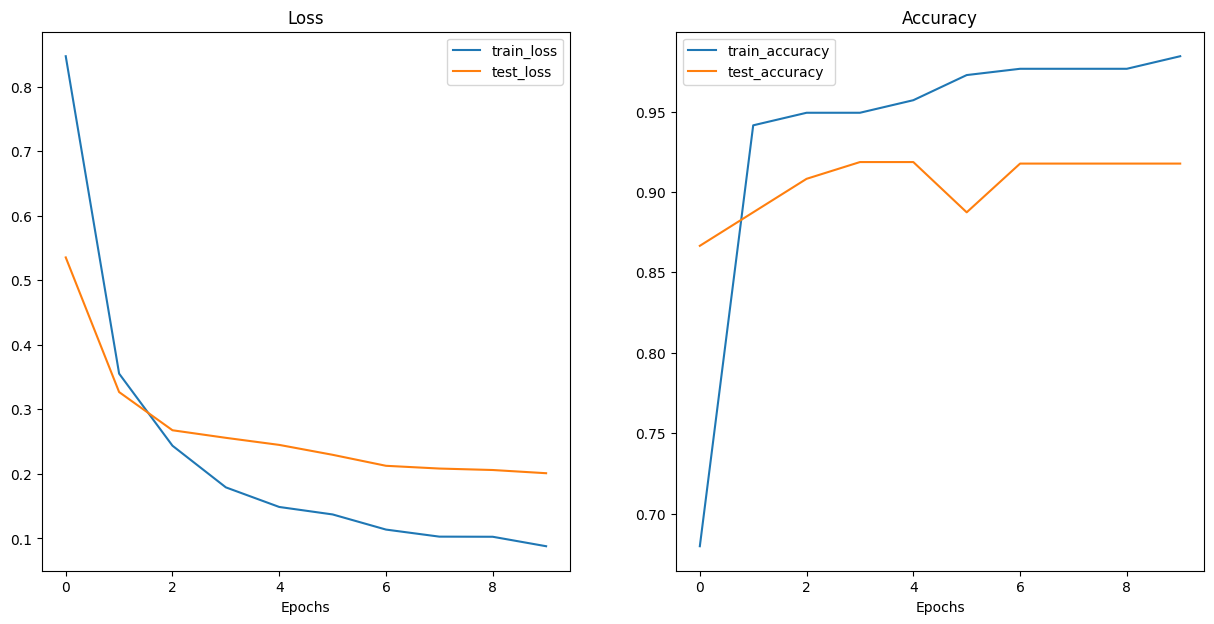

In [70]:
plot_loss_curves(results1)

In [71]:
!nvidia-smi

Wed Aug  7 05:30:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              30W /  70W |   6299MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [74]:
#Save the model
from going_modular.going_modular import utils
utils.save_model(model=pretrained_vit,
                 target_dir='models',
                 model_name='pretrained_vit.pth')

[INFO] Saving model to: models/pretrained_vit.pth


In [76]:
from pathlib import Path

#Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path('models/pretrained_vit.pth').stat().st_size // (1024*1024)
pretrained_vit_model_size

327

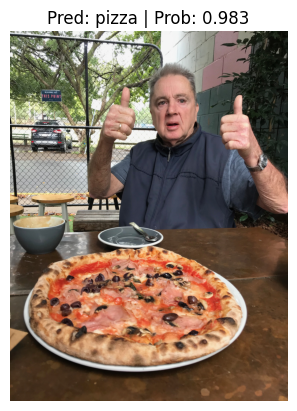

In [79]:
#Predicting on a custom image
from going_modular.going_modular.predictions import pred_and_plot_image
pred_and_plot_image(model=pretrained_vit,
                    image_path="/content/04-pizza-dad.jpeg",
                    class_names=class_names)